# Training a model

Below is the example for a Gaussian Process regression using GpyTorch :class:`.ExactGaussianProcessRegressor`

This notebook demonstrates how to perform multitask regression with kernels.IndexKernel. Multitask regression, first introduced in [this paper](https://papers.nips.cc/paper/3189-multi-task-gaussian-process-prediction.pdf) learns similarities in the outputs simultaneously. It's useful when you are performing regression on multiple functions that share the same inputs, especially if they have similarities (such as being sinusodial).

In [1]:
# import gpytorch and gpwrapper in a directory above
import sys
sys.path.append("..")

import math
import torch
import gpytorch
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from torch.autograd import Variable
# Training points are every 0.1 in [0,1] (note that they're the same for both tasks)
train_x = Variable(torch.linspace(0, 1, 11))
# y1s are indexed 0, y2s are indexed 1
y1_inds = Variable(torch.zeros(11).long())
y2_inds = Variable(torch.ones(11).long())
# y1 function is sin(2*pi*x) with noise N(0, 0.04)
train_y1 = Variable(torch.sin(train_x.data * (2 * math.pi)) + torch.randn(train_x.size()) * 0.2)
# y2 function is cos(2*pi*x) with noise N(0, 0.04)
train_y2 = Variable(torch.cos(train_x.data * (2 * math.pi)) + torch.randn(train_x.size()) * 0.2)

In [3]:
from torch import optim
from gpytorch.kernels import RBFKernel, IndexKernel
from gpytorch.means import ConstantMean
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.random_variables import GaussianRandomVariable
from gpwrapper import ExactGaussianProcessRegressor

In [4]:
class MultitaskGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(MultitaskGPModel, self).__init__(train_x, train_y, likelihood)
        # Default bounds on mean are (-1e10, 1e10)
        self.mean_module = ConstantMean()
        # We use the very common RBF kernel
        self.covar_module = RBFKernel(log_lengthscale_bounds=(-3, 3))
        # We learn an IndexKernel for 2 tasks
        # (so we'll actually learn 2x2=4 tasks with correlations)
        self.task_covar_module = IndexKernel(n_tasks=2, rank=1)

    def forward(self,x,i):
        # Get predictive mean
        mean_x = self.mean_module(x)
        # Get all covariances, we'll look up the task-speicific ones
        covar_x = self.covar_module(x)
        # # Get the covariance for task i
        covar_i = self.task_covar_module(i)
        covar_xi = covar_x.mul(covar_i)
        return GaussianRandomVariable(mean_x, covar_xi)

In [5]:
likelihood = GaussianLikelihood(log_noise_bounds=(-6, 6))
# Step 2: Wrap the model into our GP Wrapper
GP = ExactGaussianProcessRegressor(
    module = MultitaskGPModel,
    likelihood = likelihood,
    train_split = None,
)

train_x_cat = (torch.cat([train_x, train_x]),
           torch.cat([y1_inds, y2_inds]))

train_y_cat = torch.cat([train_y1.data, train_y2.data])
# Step 3: Find optimal model hyperparameters
GP.fit(X=train_x_cat, y=train_y_cat)

# Step 4: Prediction
# Test points every 0.02 in [0,1]
test_x = Variable(torch.linspace(0, 1, 51))
# Make y index vectors of the same length as test data
y1_inds_test = Variable(torch.zeros(51).long())
y2_inds_test = Variable(torch.ones(51).long())

# Make predictions
observed_pred_y1 = GP.predict_proba((test_x, y1_inds_test))
observed_pred_y2 = GP.predict_proba((test_x, y2_inds_test))

  epoch    train_loss     dur
-------  ------------  ------
      1        1.3308  0.0881
      2        1.3028  0.0224
      3        1.2839  0.0232
      4        1.2616  0.0156
      5        1.2448  0.0219
      6        1.2294  0.0203
      7        1.2086  0.0196
      8        1.1939  0.0164
      9        1.1672  0.0229
     10        1.1443  0.0212
     11        1.1235  0.0165
     12        1.1044  0.0192
     13        1.1065  0.0180
     14        1.0767  0.0198
     15        1.0852  0.0213
     16        1.0441  0.0195
     17        1.0783  0.0362
     18        1.0037  0.0223
     19        0.9304  0.0254
     20        0.9292  0.0246
     21        0.9141  0.0224
     22        0.7988  0.0254
     23        0.8563  0.0220
     24        0.7651  0.0278
     25        0.6816  0.0286
     26        0.7206  0.0204
     27        0.6579  0.0235
     28        0.6709  0.0196
     29        0.6216  0.0226
     30        0.5970  0.0235
     31        0.5960  0.0271
     32   

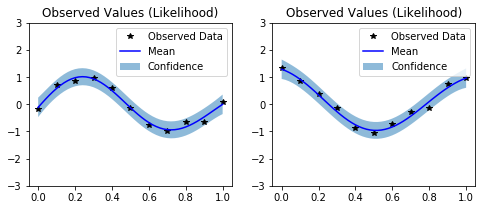

In [6]:
# Define plotting function
def ax_plot(ax, train_y, rand_var, title):
    # Get lower and upper confidence bounds
    lower, upper = rand_var.confidence_region()
    # Plot training data as black stars
    ax.plot(train_x.data.numpy(), train_y.data.numpy(), 'k*')
    # Predictive mean as blue line
    ax.plot(test_x.data.numpy(), rand_var.mean().data.numpy(), 'b')
    # Shade in confidence
    ax.fill_between(test_x.data.numpy(), lower.data.numpy(), upper.data.numpy(), alpha=0.5)
    ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])
    ax.set_title(title)

# Initialize plots
f, (y1_ax, y2_ax) = plt.subplots(1, 2, figsize=(8, 3))

# Plot both tasks
ax_plot(y1_ax, train_y1, observed_pred_y1, 'Observed Values (Likelihood)')
ax_plot(y2_ax, train_y2, observed_pred_y2, 'Observed Values (Likelihood)')

# TODO: Using sklearn pipeline and Grid search
Using a sklearn StandardScaler as pre-processing step via sklearn pipeline is hard in this case, because StandardScaler needs an array X as input, but our input to the GP Model is a tuple of X and index array.

Doing grid search is hard for the same reason.